In [1]:
from salishsea_tools import nc_tools, data_tools, tidetools, visualisations, viz_tools, stormtools, geo_tools
from collections     import OrderedDict
from matplotlib      import pyplot, animation, rcParams, patches
from dateutil        import parser
import datetime
import os
import numpy as np
import xarray

%matplotlib inline
rcParams.update({'font.size': 12})
rcParams["axes.formatter.useoffset"] = False

In [33]:
timerange = ['2016 Jan 1 00:00', '2016 Jan 31 00:00']
starttime, endtime = map(parser.parse, timerange)

In [34]:
NEMO = nc_tools.load_NEMO_from_erddap(timerange, depth=[0, 1]).isel(depth=0)
GEM  = nc_tools.load_GEM_from_erddap( timerange)

In [35]:
Stations = [
    'PamRocks',
    'SistersIsland',
    'EntranceIsland',
    'Sandheads',
    'YVR',
    'PointAtkinson',
    'Victoria',
    'CampbellRiver',
    'PatriciaBay',
    'Esquimalt',
]

EC_wind = {}

for station in Stations:
    
    DATA = stormtools.get_EC_observations(station,
                               datetime.datetime.strftime(starttime, '%d-%b-%Y'),
                               datetime.datetime.strftime(endtime,   '%d-%b-%Y'))
    
    j, i = geo_tools.find_closest_model_point(
    DATA[5], DATA[4], GEM.longitude, GEM.latitude,
    grid='GEM2.5', land_mask=NEMO.mask)
    
    EC_wind[station] = xarray.Dataset({
                'lon'    : DATA[5],
                'lat'    : DATA[4],
                'i_coord': i,
                'j_coord': j,
                'windspd': ('time', DATA[0]),
                'winddir': ('time', DATA[1]),
                'u_wind' : ('time', -1 * DATA[0] * np.cos(np.radians(DATA[1]))),
                'v_wind' : ('time', -1 * DATA[0] * np.sin(np.radians(DATA[1])))},      
                coords={'time': DATA[3]})

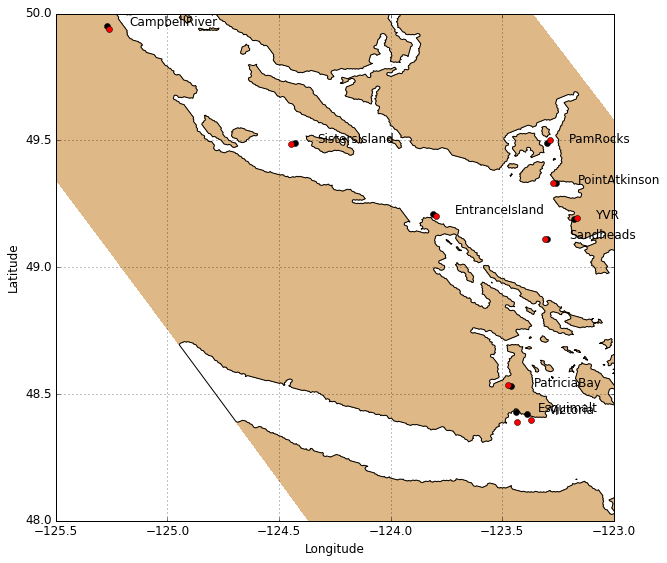

In [54]:
# Create figure
fig, ax = pyplot.subplots(1, 1, figsize=(10, 10))
visualisations.create_figure(ax, NEMO.isel(time=0), window=[-125.5, -123, 48, 50])
for station in Stations:
    i = EC_wind[station].i_coord.values.item()
    j = EC_wind[station].j_coord.values.item()
    pyplot.plot(EC_wind[station].lon, EC_wind[station].lat, 'ko')
    pyplot.plot(GEM.longitude.isel(gridX=i, gridY=j), GEM.latitude.isel(gridX=i, gridY=j), 'ro')
    ax.text(EC_wind[station].lon+.1, EC_wind[station].lat, station)

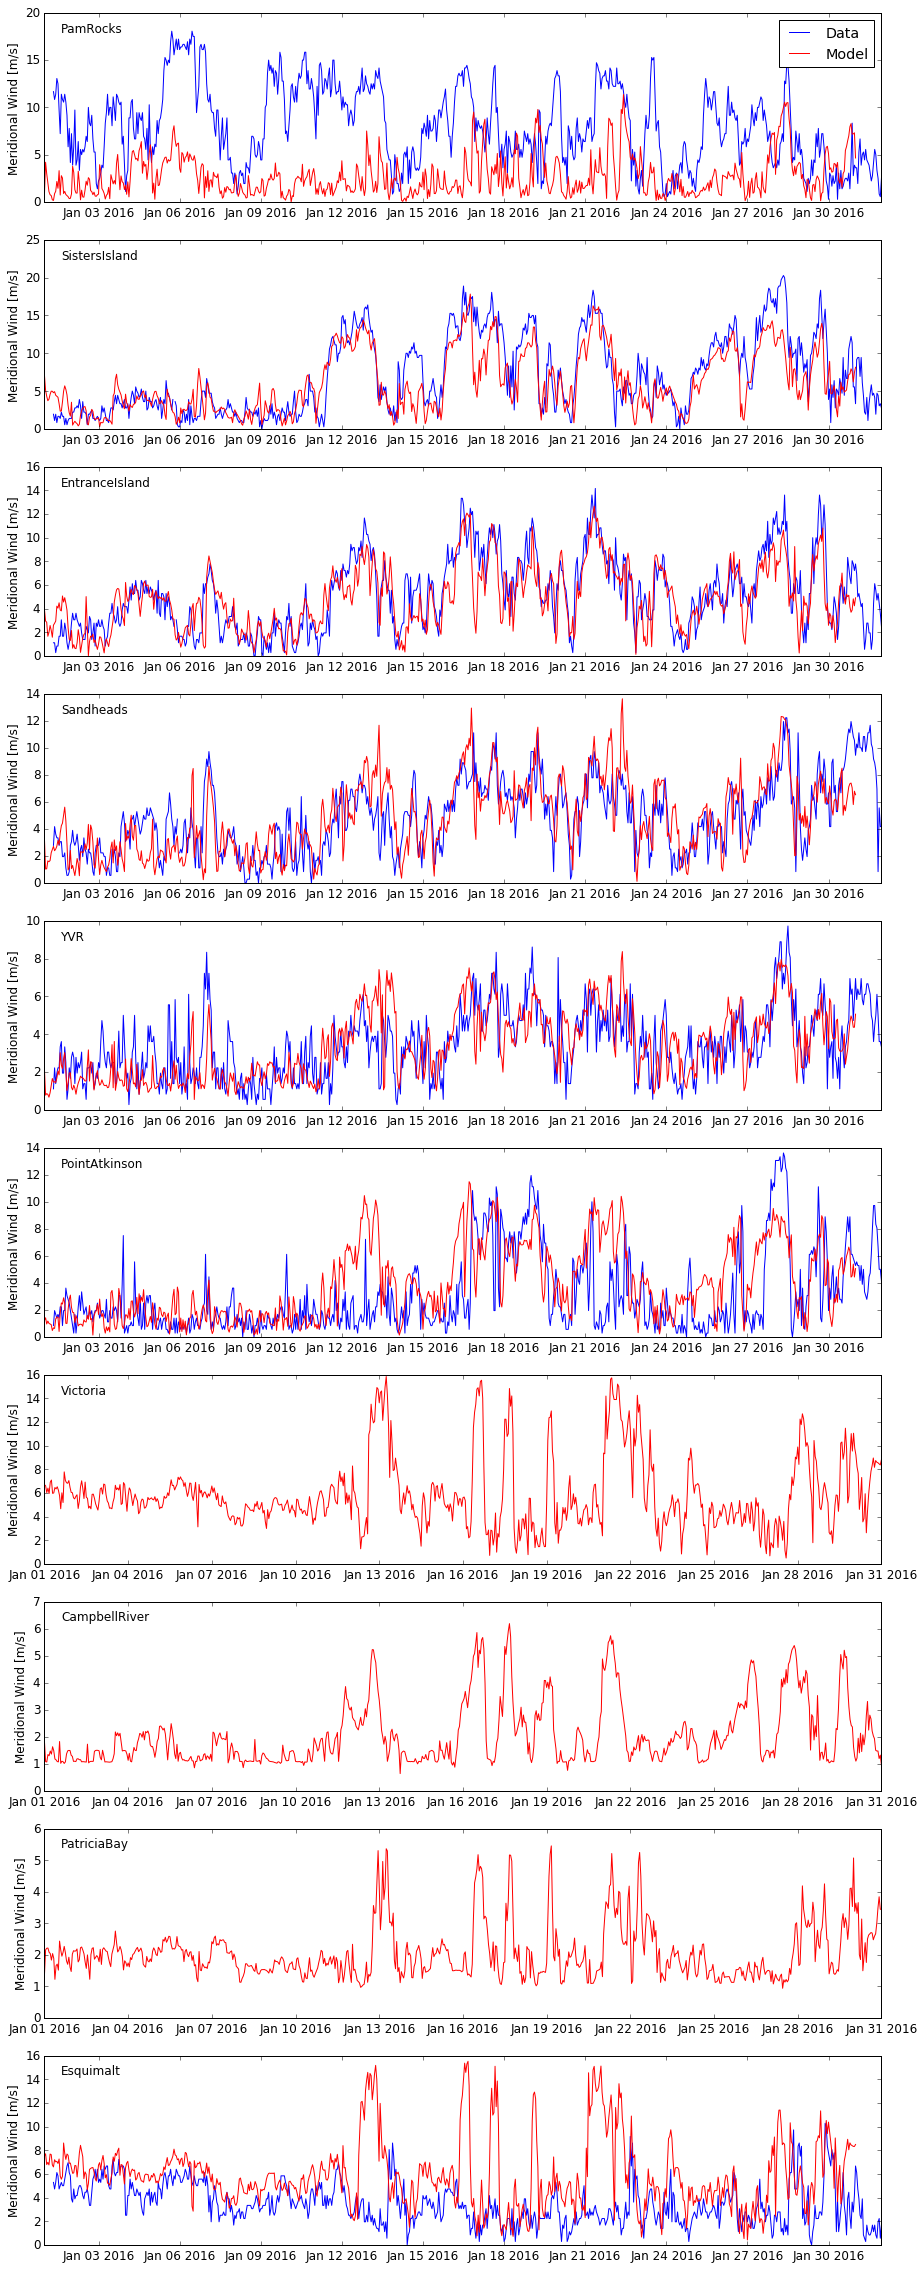

In [58]:
fig, ax = pyplot.subplots(10, 1, figsize=(15, 40))

for index, station in enumerate(Stations):
    i = EC_wind[station].i_coord.values.item()
    j = EC_wind[station].j_coord.values.item()
    ax[index].plot(EC_wind[station].time, EC_wind[station].windspd, 'b-')
    ax[index].plot(GEM.time, np.sqrt(GEM.u_wind.isel(gridX=i, gridY=j)**2 + GEM.v_wind.isel(gridX=i, gridY=j)**2), 'r-')
    ax[index].text(0.02, 0.9, station, transform=ax[index].transAxes)
    ax[index].set_ylabel('Windspeed [m/s]')
    
ax[0].legend(labels=['Data', 'Model'])